<h1>DSS 740: Analytics with Machine Learning (Fall 2025)</h1>
<h2 style = 'color:yellow'>OH 4.2: Classification Analysis</h2>
<h3 style = 'color:green'>4.2.0 Import Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

<h3 style = 'color:green'>4.2.1 Load and Explore Dataset</h3>

In [2]:
df = pd.read_csv("../../data/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.dropna(inplace=True, axis=0)

In [5]:
np.round(df['ocean_proximity'].value_counts(normalize=True) * 100, 2)

ocean_proximity
<1H OCEAN     44.21
INLAND        31.79
NEAR OCEAN    12.86
NEAR BAY      11.11
ISLAND         0.02
Name: proportion, dtype: float64

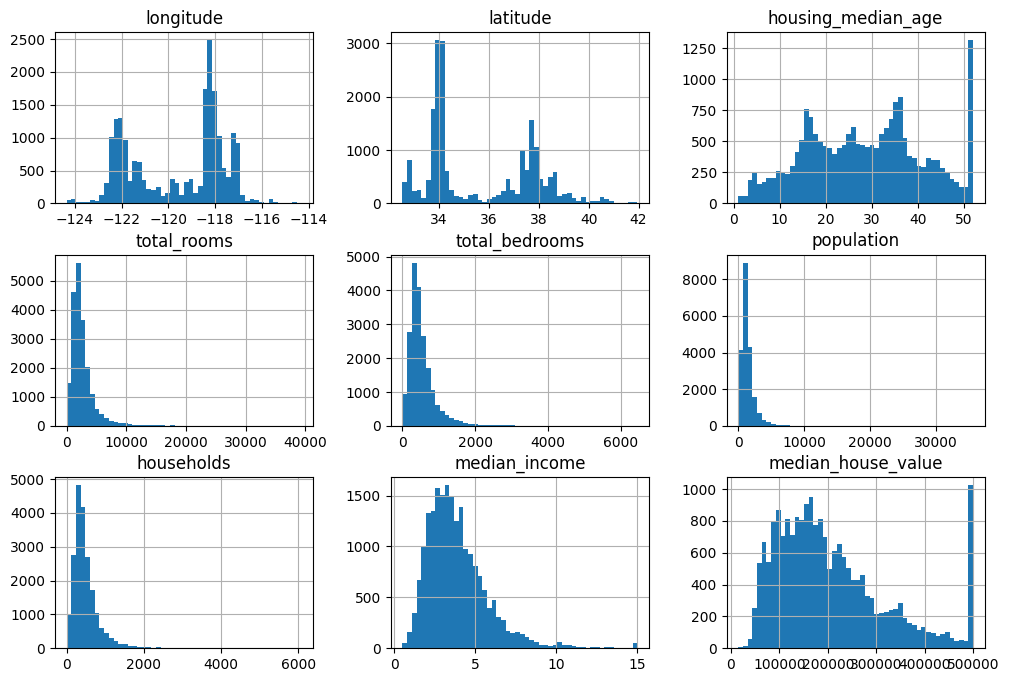

In [6]:
df.hist(bins=50, figsize=(12,8))
plt.show()

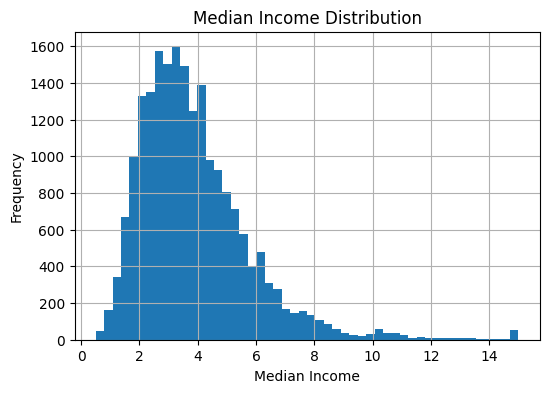

In [7]:
# To show distribution of any one column
df['median_income'].hist(bins=50, figsize=(6,4))
plt.title('Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

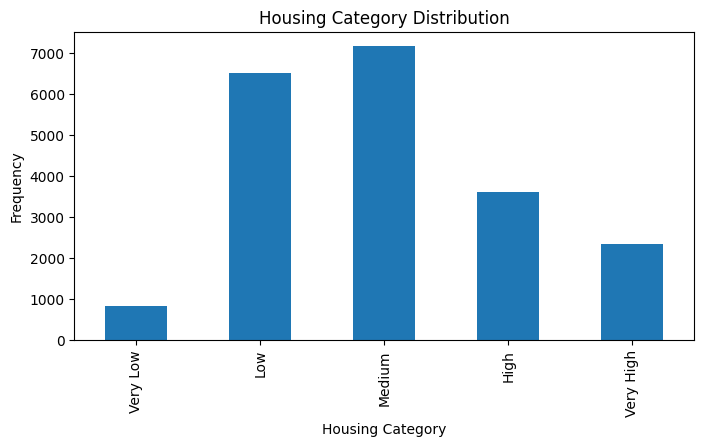

In [8]:
# Another way to represent the median income data is to create a categorical column where each category represents a different income range.
df['housing_category'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df['housing_category'].value_counts().sort_index().plot(kind='bar', figsize=(8,4)) # Value_counts sorts the data using labels and not by the logical order of the bins. To fix that we use sort_index()
plt.title('Housing Category Distribution')
plt.xlabel('Housing Category')
plt.ylabel('Frequency')
plt.show()

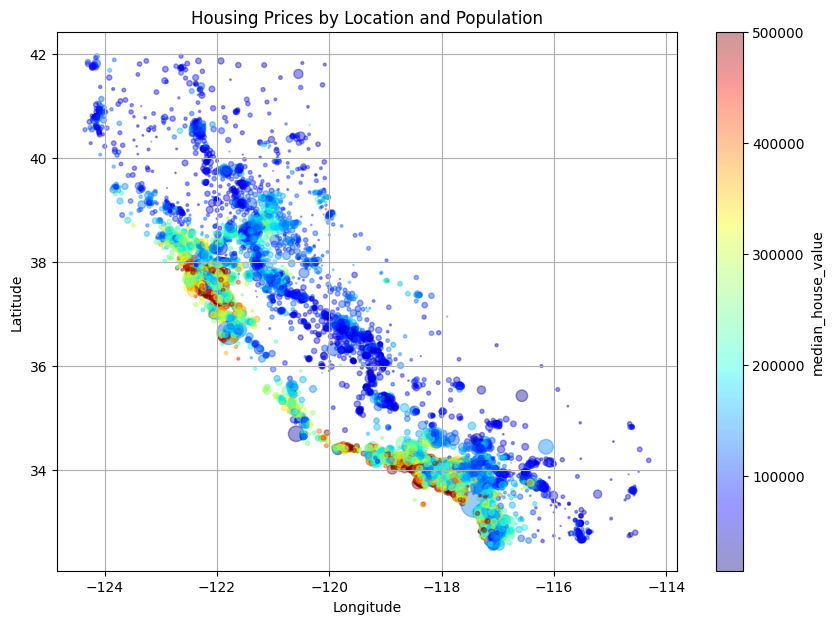

In [9]:
# Let's visualize the location of the houses
df.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
        grid=True, s = df['population']/100, label = "population",
        c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True,
        legend = False, sharex = False, figsize = (10,7))
plt.title("Housing Prices by Location and Population")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [10]:
# Let's look at the correlation between the features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()
np.round(correlation_matrix['median_house_value'].sort_values(ascending=False), 4)

median_house_value    1.0000
median_income         0.6884
total_rooms           0.1333
housing_median_age    0.1064
households            0.0649
total_bedrooms        0.0497
population           -0.0253
longitude            -0.0454
latitude             -0.1446
Name: median_house_value, dtype: float64

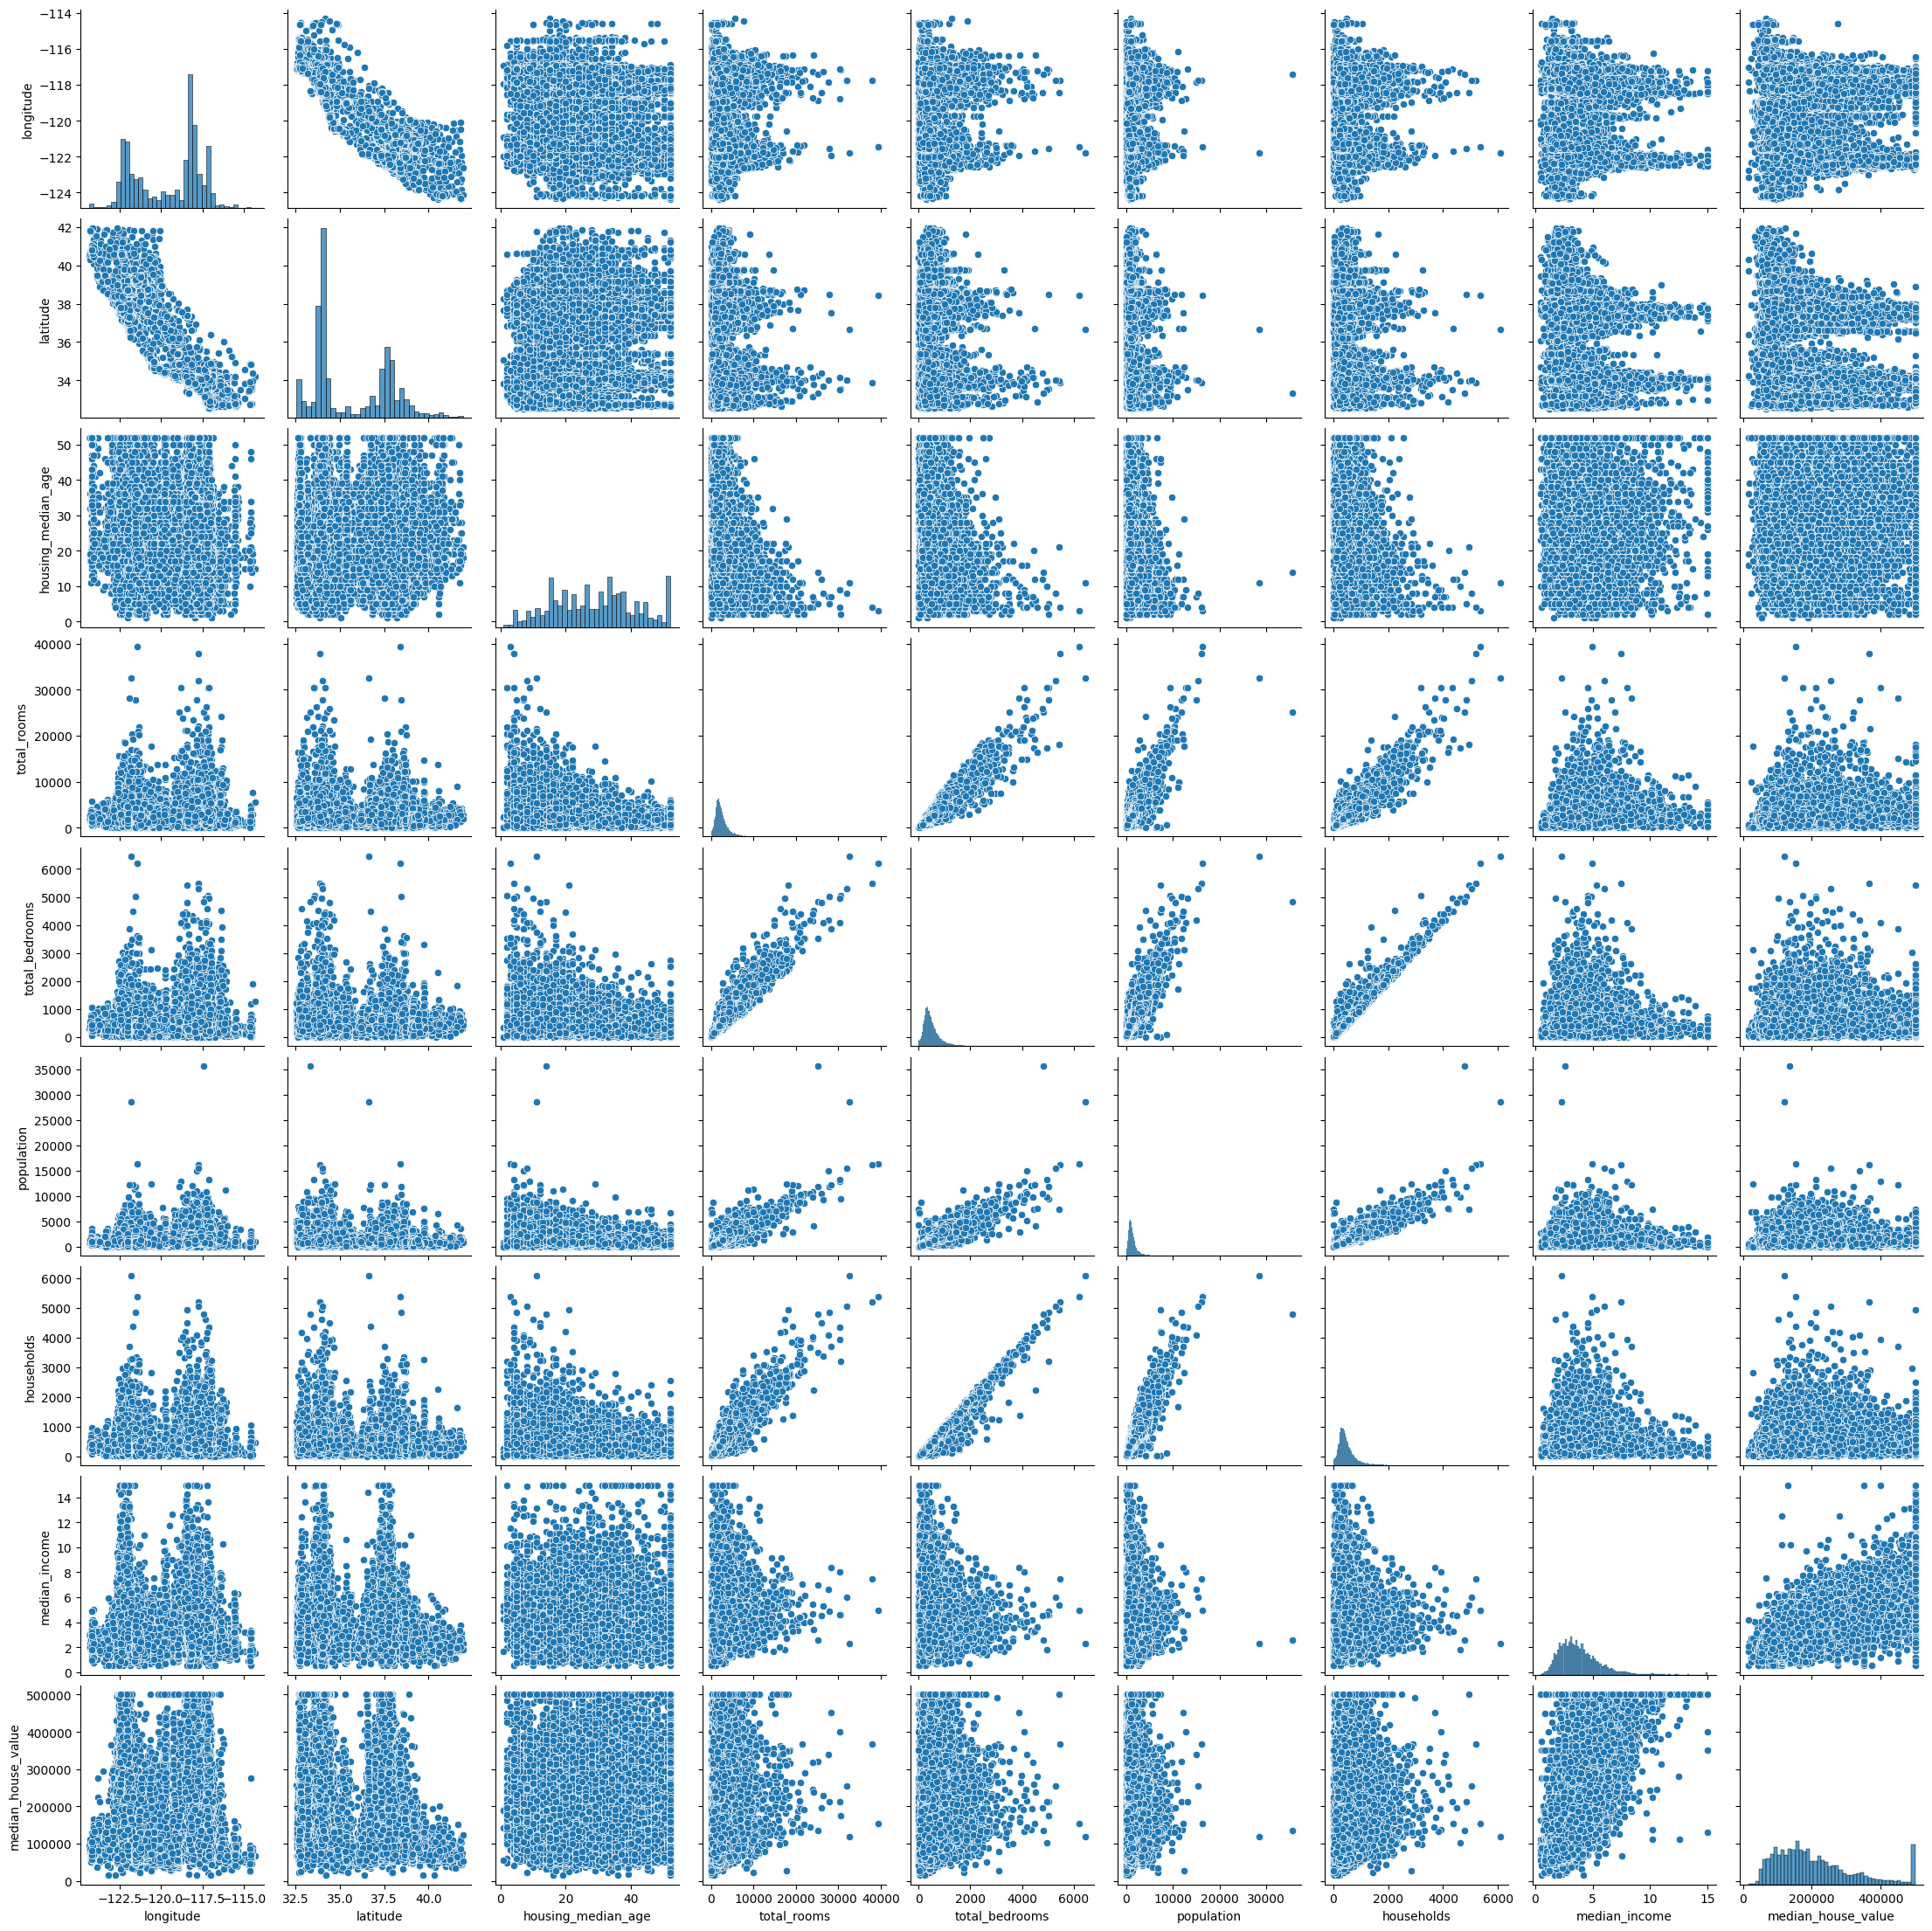

In [11]:
# Let's create a pairplot to visualize relationships between features
sns.pairplot(df[numerical_features])
plt.show()

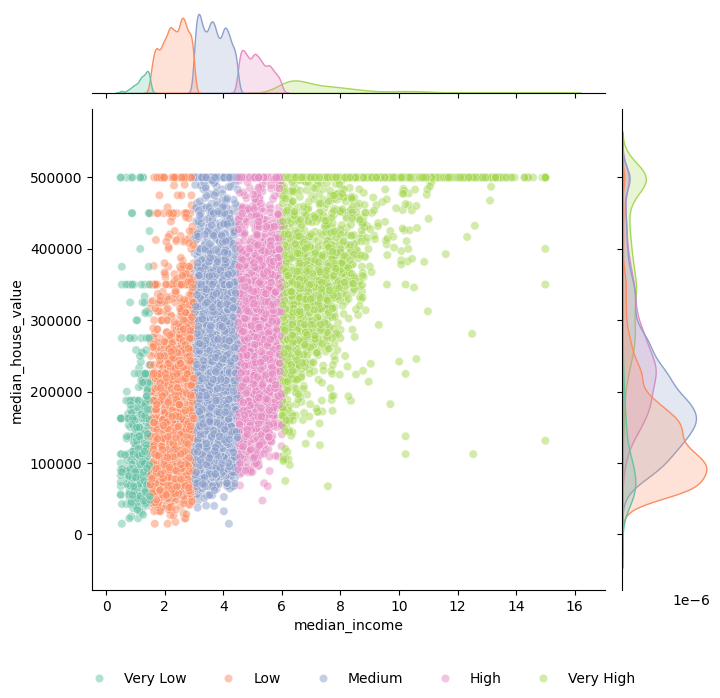

In [12]:
g = sns.jointplot(
    x='median_income', y='median_house_value',
    data=df, kind='scatter', alpha=0.5,
    hue='housing_category', palette='Set2', height=7
)

handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend_.remove()  # remove auto legend
g.fig.legend(handles, labels, loc='lower center', ncol=5, frameon=False)
g.fig.subplots_adjust(bottom=0.15)  # space for bottom legend
plt.show()

<h3 style = 'color:green'>4.2.2 Feature Engineering</h3>

Let's create a few new features that might be useful for our model
<ol>
    <li><b>Rooms per house</b>: This feature will tell us how many rooms we have per household size.</li>
    <li><b>Bedrooms per house</b>: This feature will tell us how many bedrooms we have as compared to the total number of rooms in the house.</li>
    <li><b>People per house</b>: This feature will tell us how many people live in each house.</li>
</ol>

In [13]:
df['rooms_per_house'] = df['total_rooms'] / df['households']
df['bedrooms_ratio'] = df['total_bedrooms'] / df['total_rooms']
df['people_per_house'] = df['population'] / df['households']

In [14]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()
np.round(correlation_matrix['median_house_value'].sort_values(ascending=False), 4)

median_house_value    1.0000
median_income         0.6884
rooms_per_house       0.1513
total_rooms           0.1333
housing_median_age    0.1064
households            0.0649
total_bedrooms        0.0497
people_per_house     -0.0236
population           -0.0253
longitude            -0.0454
latitude             -0.1446
bedrooms_ratio       -0.2559
Name: median_house_value, dtype: float64

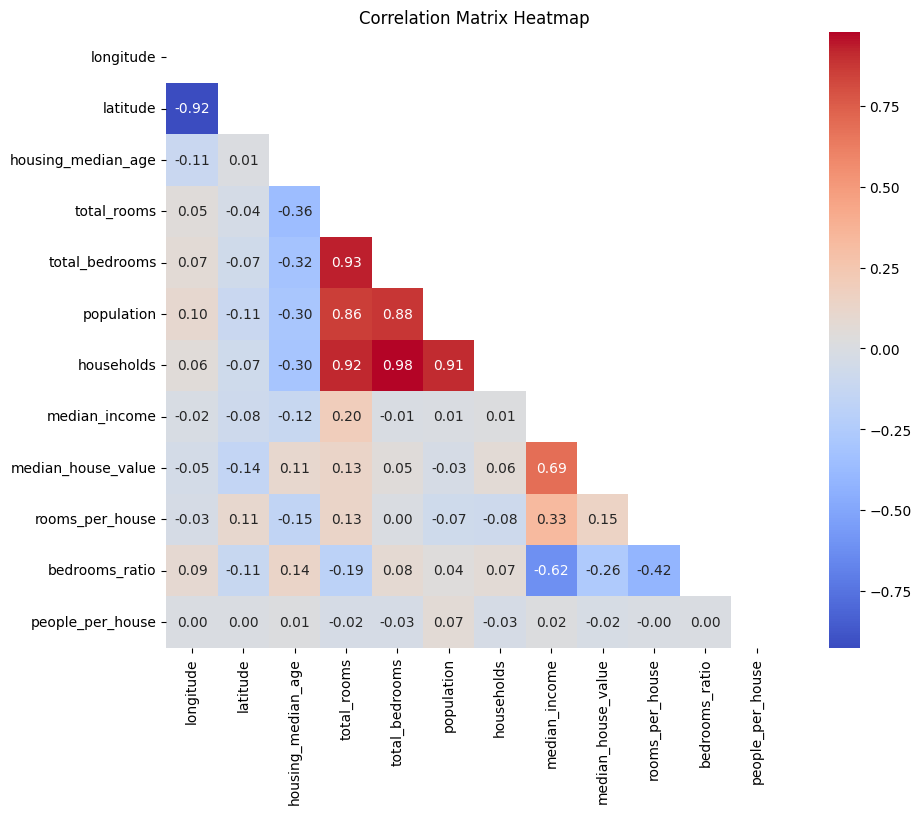

In [15]:
# Create a simple heatmap to visualize the correlation between the new features
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # Mask to show only one triangle. The way this works is to only show the lower triangle of the matrix.
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()


<h3 style = 'color:green'>4.2.3 Prepare Data for Machine Learning (Classification)</h3>

<h4 style = 'color:lightgreen'>4.2.2.1 Impute and Encode Data</h4>

In [16]:
housing_numerical_features = df.select_dtypes(include=[np.number])

In [17]:
housing_numerical_features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467


In [18]:
simple_imputer = SimpleImputer(strategy='median')
simple_imputer.fit(housing_numerical_features)
np.round(simple_imputer.statistics_, 2) # The median values for each numerical column

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5400e+00,  1.7970e+05,  5.2300e+00,
        2.0000e-01,  2.8200e+00])

One way to encode categorical data is to use the pandas function <code>get_dummies</code>. This creates binary columns for each category.

In [19]:
housing_categorical_features = df.select_dtypes(include=['object'])
housing_categorical_features.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


In [20]:
pd.get_dummies(housing_categorical_features, drop_first=True, dtype=int).head()

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


Another way to encode categorical data is to use the <code>OneHotEncoder</code> from sklearn.preprocessing. This technique creates a <b>sparse representation</b> of categorical features. For datasets that have a large number of categorical columns, <code>get_dummies()</code> can lead to memory issues since there will be a lot of columns with a lot of zeros. A sparse representation can be more memory-efficient because it only stores the non-zero values and the indices of those non-zero values.

In [21]:
categorical_encoder = OneHotEncoder(drop='first')
housing_categorical_1hot = categorical_encoder.fit_transform(housing_categorical_features)
categorical_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

The following code demonstrates how to encode categorical data using both <code>get_dummies</code> and <code>OneHotEncoder</code>. It compares the memory usage of the encoded data using both techniques. In the case of a dataset that has fewer categorical columns, <code>get_dummies</code> may be more memory-efficient. For larger datasets with lots of zeros, <code>OneHotEncoder</code> may be more memory-efficient.

You can convert the sparse matrix to a dense matrix using the <code>toarray()</code> method.

In [ ]:
# print("➡ Original data shape:", data.shape)

# # Using Pandas get_dummies() — DENSE matrix
# dense_encoded = pd.get_dummies(data, drop_first=True)
# print("Dense encoded shape:", dense_encoded.shape)

# # Using OneHotEncoder — SPARSE matrix
# encoder = OneHotEncoder(drop='first', sparse_output=True)
# sparse_encoded = encoder.fit_transform(data)

# print("Sparse encoded shape:", sparse_encoded.shape)
# print("Sparse matrix type:", type(sparse_encoded))
# print("Stored elements:", sparse_encoded.nnz)  # number of nonzero values

# # Compare memory usage
# dense_memory = dense_encoded.memory_usage(deep=True).sum()
# sparse_memory = (sparse_encoded.data.nbytes + 
#                  sparse_encoded.indptr.nbytes + 
#                  sparse_encoded.indices.nbytes)

# print(f"\nDense matrix memory usage: {dense_memory/1024:.2f} KB")
# print(f"Sparse matrix memory usage: {sparse_memory/1024:.2f} KB")
# print(f"Compression ratio: {dense_memory/sparse_memory:.1f}x smaller with sparse representation")

In [22]:
housing_categorical_1hot.toarray()

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

If a categorical feature has a lot of categories, one-hot encoding can lead to a large number of columns, which will slow down the model training process. If this happens, consider replacing the categorical features with meaningful numerical features using feature engineering techniques.

<h4 style = 'color:lightgreen'>4.2.2.2 Scale Data</h4>

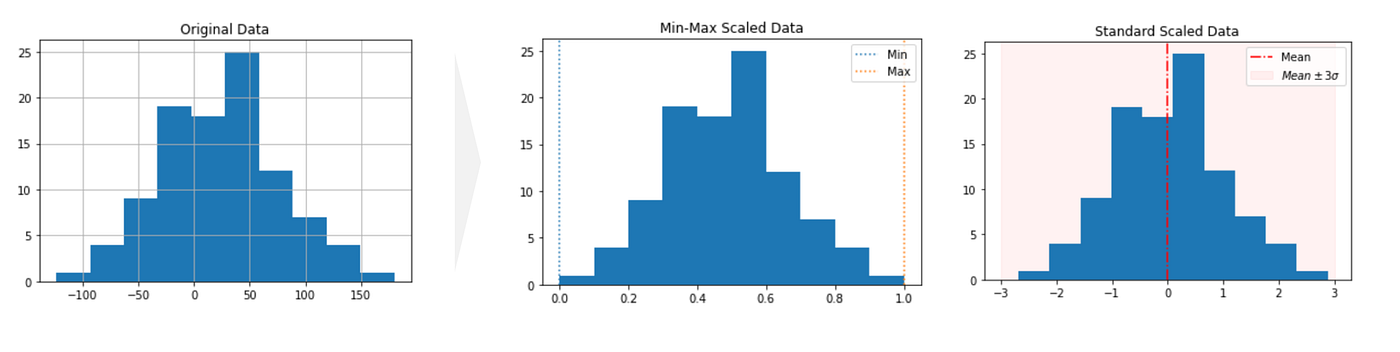

Source: <a href = "https://medium.com/@vinodkumargr/07-standardization-and-normalization-techniques-in-machine-learning-standardscaler-3890a89bddbf">Standardization and Normalization Techniques in Machine Learning</a>

When a feature's distribution has a heavy tail (i.e., when values far from the mean are not exponentially rare), both min-max scaling and standardization will squash most values into a small range. Machine learning algorithms generally don't like this. So, before you scale the fatures, you should first transform it to shrink the heavy tail, and if possible to make the distribution more symmetrical.

For example, a common way to do this for positive features with heavy tails is to replace the feature with its square root or logarithm of the feature. This is called logarithmic transformation.

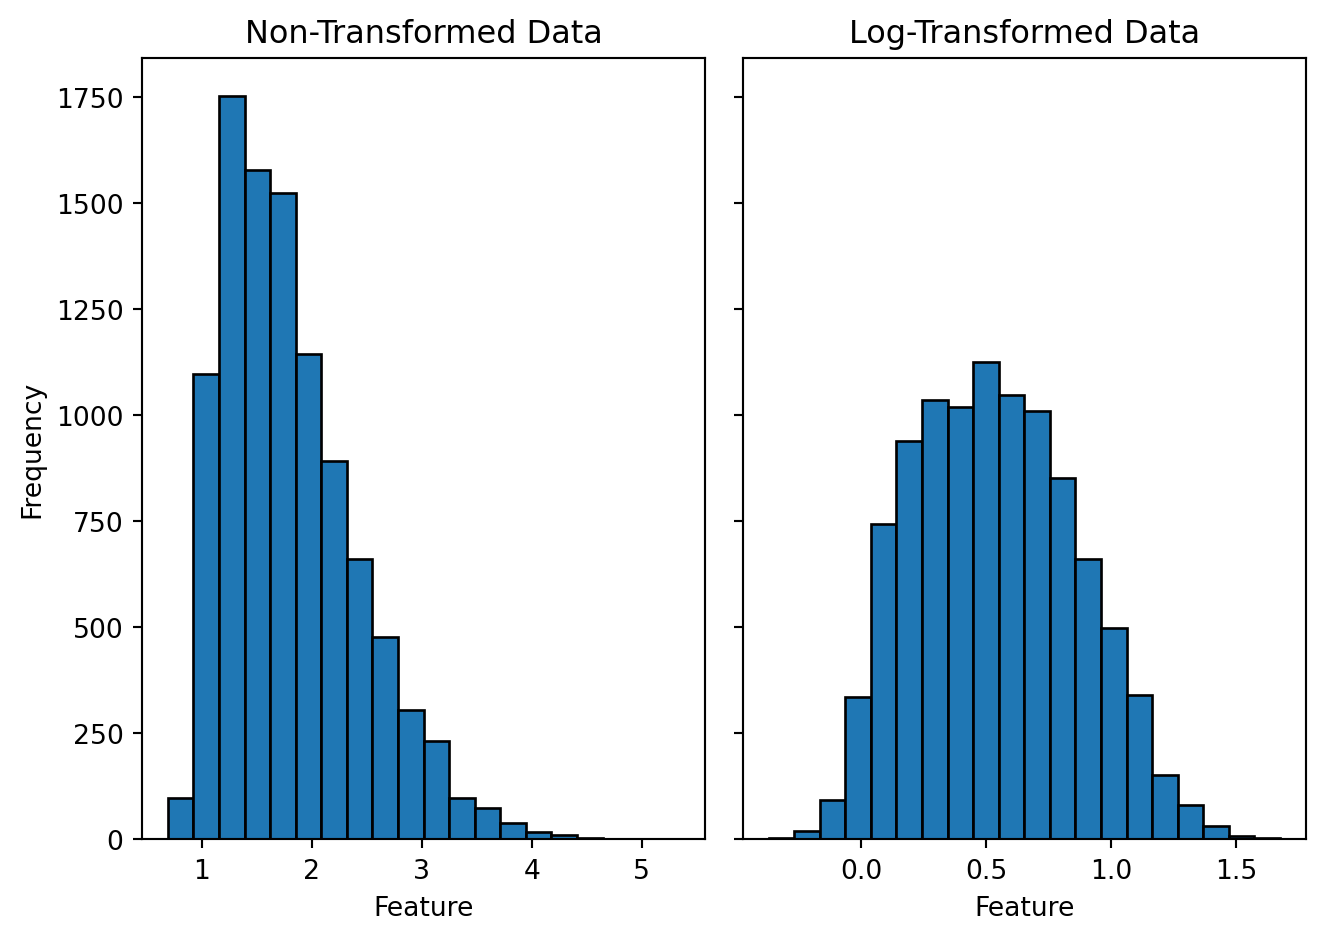

Source: <a href = "https://dataalltheway.com/posts/001-data-transformation/index.html">Data Transformation</a>

In [23]:
target_scalar = StandardScaler()
scaled_values = target_scalar.fit_transform(housing_numerical_features)
scaled_housing_numerical_features = pd.DataFrame(scaled_values, columns=housing_numerical_features.columns)

In [24]:
# Build a simple linear regression model
X_train, X_test, y_train, y_test = train_test_split(scaled_housing_numerical_features, df['median_house_value'], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [25]:
predictions = model.predict(X_test)
predictions[:5]

array([ 80100., 500001., 352100., 187500., 361000.])

In [26]:
y_test[:5]

14425     80100.0
16398    500001.0
7721     352100.0
1411     187500.0
1336     361000.0
Name: median_house_value, dtype: float64

<h4 style = 'color:lightgreen'>4.2.2.3 Custom Transformers</h4>

<b>Function Transformers</b> are a powerful way to create custom transformers for your machine learning pipeline. They allow you to perform custom data transformations during the preprocessing stage.

In [27]:
log_transformer = FunctionTransformer( 
    lambda X: np.log1p(np.clip(X, 0, None)),
    feature_names_out='one-to-one')
log_population = log_transformer.fit_transform(df[['population']])
df['log_population'] = log_population
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,housing_category,rooms_per_house,bedrooms_ratio,people_per_house,log_population
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,Very High,6.984127,0.146591,2.555556,5.777652
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,Very High,6.238137,0.155797,2.109842,7.784057
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,Very High,8.288136,0.129516,2.802260,6.208590
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,High,5.817352,0.184458,2.547945,6.326149
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,Medium,6.281853,0.172096,2.181467,6.338594


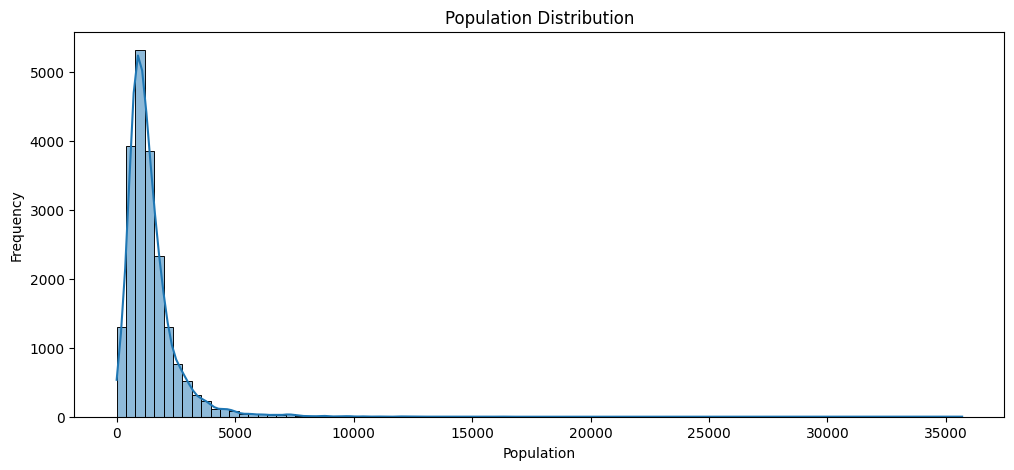

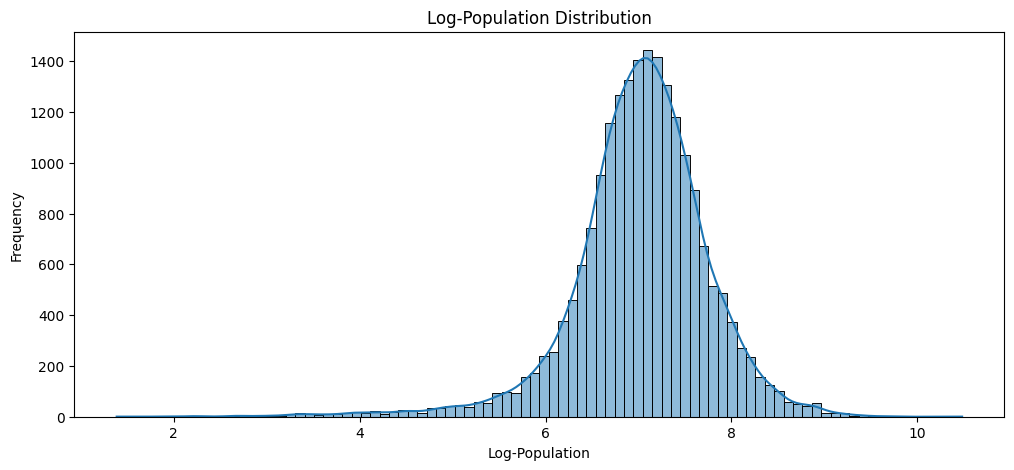

In [28]:
# Let's plot the population and log_population distributions using a histogram
plt.figure(figsize=(12,5))
sns.histplot(df['population'], bins=90, kde=True)
plt.title('Population Distribution')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['log_population'], bins=90, kde=True)
plt.title('Log-Population Distribution')
plt.xlabel('Log-Population')
plt.ylabel('Frequency')
plt.show()

<h4 style = 'color:lightgreen'>4.2.2.4 Pipelines</h4>

<b>Pipelines</b> are a powerful way to automate the data preprocessing and model training process. They allow you to chain multiple transformers and estimators together into a single pipeline.

In [29]:
df.dropna(inplace=True, axis=0)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  float64 
 3   total_rooms         20433 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20433 non-null  float64 
 6   households          20433 non-null  float64 
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  object  
 10  housing_category    20433 non-null  category
 11  rooms_per_house     20433 non-null  float64 
 12  bedrooms_ratio      20433 non-null  float64 
 13  people_per_house    20433 non-null  float64 
 14  log_population      20433 non-null  float64 
dtypes: category(1), float64(13), object(1)
me

In [31]:
# Creating a binary target variable based on median_house_value
v = df["median_house_value"]
th = v.quantile(0.75)                   # top quartile
df["median_house_value_category"] = (v >= th).map({False:"Low Value", True:"High Value"})

In [32]:
X = df.drop(['median_house_value_category', 'median_house_value'], axis=1)
y = df['median_house_value_category']
y = pd.Categorical(y, categories=["Low Value","High Value"], ordered=True)
# integer y if you want: 0 = Low, 1 = High
y_int = y.map({"Low Value":0, "High Value":1}).astype(int)
X.shape, y.shape

C:\Users\Owner\AppData\Local\Temp\ipykernel_58536\1731440410.py:5: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  y_int = y.map({"Low Value":0, "High Value":1}).astype(int)


((20433, 14), (20433,))

In [33]:
housing_numerical_features = X.select_dtypes(include=[np.number]).columns
housing_categorical_features = X.select_dtypes(include=['object']).columns

In [34]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),        # fix NaNs first
    ("log", log_transformer),                             # no NaNs from log
    ("post_imputer", SimpleImputer(strategy="constant",   # safety net if any remain
                                   fill_value=0.0)),
    ("scaler", StandardScaler()),
])

housing_numerical_column_prepared = numerical_pipeline.fit_transform(X[housing_numerical_features])
housing_numerical_column_prepared[:1]

array([[ 0.        ,  1.06140573,  0.87671697, -1.13094958, -1.63362793,
        -1.6941981 , -1.56892104,  1.99533031,  1.07059195, -1.20623599,
        -0.39934877, -1.6454423 ]])

In [35]:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fix NaNs
    ("onehot", OneHotEncoder(drop="first")),               # one-hot encode
])

housing_categorical_column_prepared = categorical_pipeline.fit_transform(X[housing_categorical_features])
housing_categorical_column_prepared[:1]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 4)>

In [36]:
housing_categorical_column_prepared.toarray()[:1]

array([[0., 0., 1., 0.]])

If you have columns with different data types, you could use a <code>ColumnTransformer</code> to combine both pipelines.

In [37]:
numerical_attributes = list(housing_numerical_features)
categorical_attributes = list(housing_categorical_features)

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_attributes),
    ("cat", categorical_pipeline, categorical_attributes),
])

In [38]:
transformed_df = preprocessor.fit_transform(X)
transformed_df[:1]

array([[ 0.        ,  1.06140573,  0.87671697, -1.13094958, -1.63362793,
        -1.6941981 , -1.56892104,  1.99533031,  1.07059195, -1.20623599,
        -0.39934877, -1.6454423 ,  0.        ,  0.        ,  1.        ,
         0.        ]])

<h3 style = 'color:green'>4.2.3 Build Classification Models</h3>

In [39]:
transformed_df.shape

(20433, 16)

In [40]:
y.shape

(20433,)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16346, 16), (4087, 16), (16346,), (4087,))

In [42]:
np.round(y_train.value_counts() * 100, 2)

Low Value     1227400
High Value     407200
Name: count, dtype: int64

<h4 style = 'color:lightgreen'>4.2.3.1 Logistic Regression Model</h4>

In [43]:
# Build a Logistic Regression model
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train, y_train)
y_pred = lrBase.predict(X_test)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

Out of all predictions, 1735 houses were correctly classified as ‘Low value’ and 1662 as ‘High value’. However, 328 ‘High value’ houses were incorrectly predicted as ‘Low value’ (False Negatives), and 362 ‘Low value’ houses were incorrectly predicted as ‘High value’ (False Positives).

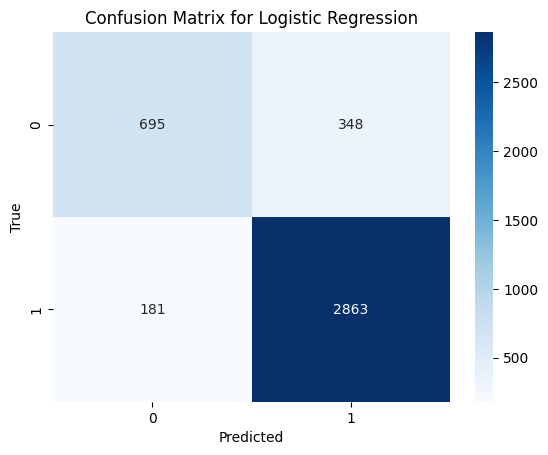

In [44]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Logistic Regression')
plt.show()

In [45]:
# Let's evaluate the model's performance by calculating accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='High Value')
recall = recall_score(y_test, y_pred, pos_label='High Value')
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
f1 = f1_score(y_test, y_pred, pos_label='High Value')
print(f'Logistic Regression Model Performance:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1-score: {f1:.4f}')

Logistic Regression Model Performance:
Accuracy: 0.8706
Precision: 0.7934
Recall: 0.6663
Specificity: 0.6663
F1-score: 0.7243


Precision: When the model predicts "High" (or "Low"), ~83% - 84% of those predictions are correct.<br>
Recall / Sensitivity (True Positive Rate): The model correctly identifies ~84% of actual "High" (or "Low") and ~82% of actual "low" houses.<br>
Specificity (True Negative Rate): How well does the model correctly identifies the "low" houses?

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  High Value       0.79      0.67      0.72      1043
   Low Value       0.89      0.94      0.92      3044

    accuracy                           0.87      4087
   macro avg       0.84      0.80      0.82      4087
weighted avg       0.87      0.87      0.87      4087



<h4 style = 'color:lightgreen'>4.2.3.2 Support Vector Machine Model</h4>

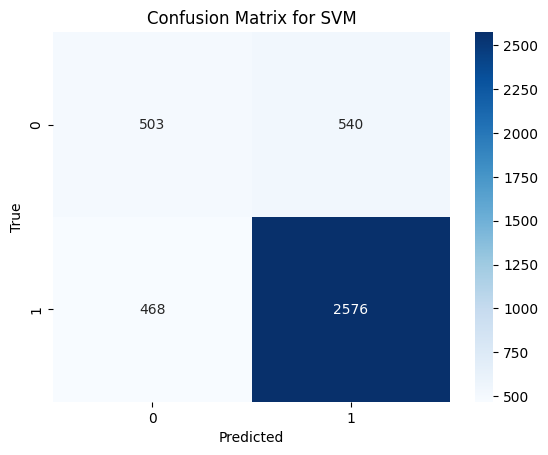

In [47]:
# SVM Model
svmBase = SVC(kernel='sigmoid', C=10, random_state=42)
svmBase.fit(X_train, y_train)
y_pred_svm = svmBase.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for SVM')
plt.show()

In [48]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

  High Value       0.52      0.48      0.50      1043
   Low Value       0.83      0.85      0.84      3044

    accuracy                           0.75      4087
   macro avg       0.67      0.66      0.67      4087
weighted avg       0.75      0.75      0.75      4087



<h4 style = 'color:lightgreen'>4.2.3.3 Naive Bayes Model</h4>

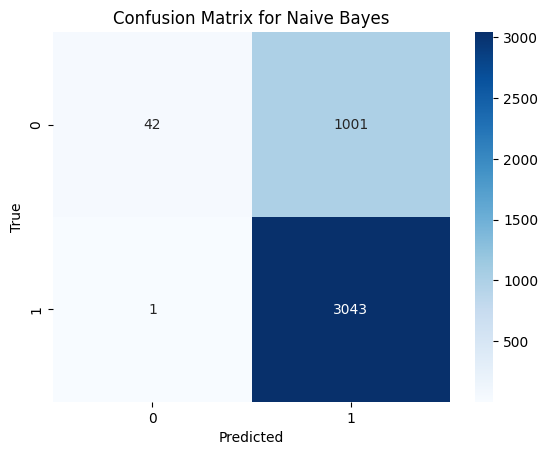

In [49]:
naive_bayesBase = GaussianNB()
naive_bayesBase.fit(X_train, y_train)
y_pred_nb = naive_bayesBase.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Naive Bayes')
plt.show()

In [50]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

  High Value       0.98      0.04      0.08      1043
   Low Value       0.75      1.00      0.86      3044

    accuracy                           0.75      4087
   macro avg       0.86      0.52      0.47      4087
weighted avg       0.81      0.75      0.66      4087



<h4 style = 'color:lightgreen'>4.2.3.4 K-Nearest Neighbor Model</h4>

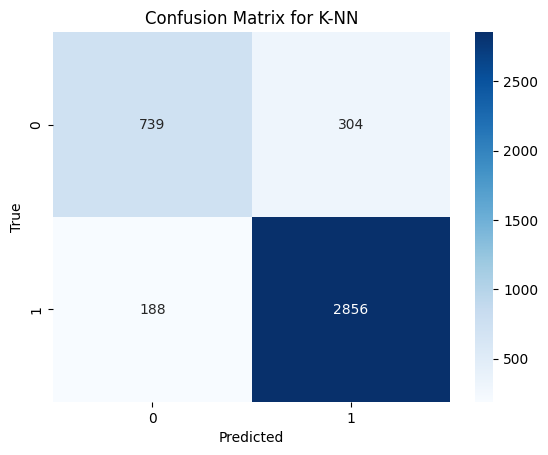

In [51]:
# K-NN Model
knnBase = KNeighborsClassifier(n_neighbors=5)
knnBase.fit(X_train, y_train)
y_pred_knn = knnBase.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for K-NN')
plt.show()

In [52]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

  High Value       0.80      0.71      0.75      1043
   Low Value       0.90      0.94      0.92      3044

    accuracy                           0.88      4087
   macro avg       0.85      0.82      0.84      4087
weighted avg       0.88      0.88      0.88      4087



<h3 style = 'color:green'>4.2.4 Evaluate Classification Models</h3>

The <b>ROC Curve</b> (Receiver Operating Characteristic) is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The x-axis plots the False Positive Rate (1 - specificity), meaning how many low value houses were wrongly predicted as high value, whereas the y-axis plots the True Positive Rate (Sensitivity), meaning how many high value houses were correctly predicted.

The closer the curve is to the corner, the better the model is at correctly identifying the high-value homes without mistakingly calling low value homes as high value.

In [53]:
POS = "High Value"   # the positive class in your y
models = {
    "Logistic Regression": lrBase,
    "Support Vector Machine": svmBase,   # SVC(probability=True) preferred
    "Naive Bayes": naive_bayesBase,
    "K-Nearest Neighbors": knnBase,
}

In [54]:
def positive_scores(clf, X, pos_label=POS):
    """
    Return scores for the positive class (pos_label).
    Uses predict_proba if available; otherwise decision_function.
    Ensures scores increase with P(pos_label).
    """
    # predict_proba → pick the correct column by class name
    if hasattr(clf, "predict_proba"):
        cls = clf.classes_
        j = int(np.where(cls == pos_label)[0][0])  # index of positive class
        return clf.predict_proba(X)[:, j]

    # decision_function → ensure sign matches pos_label
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        # If classes_ exist and classes_[1] != pos_label, flip the sign
        if hasattr(clf, "classes_") and clf.classes_.shape[0] == 2:
            if clf.classes_[1] != pos_label:
                s = -s
        return s

    raise ValueError("Classifier must implement predict_proba or decision_function.")

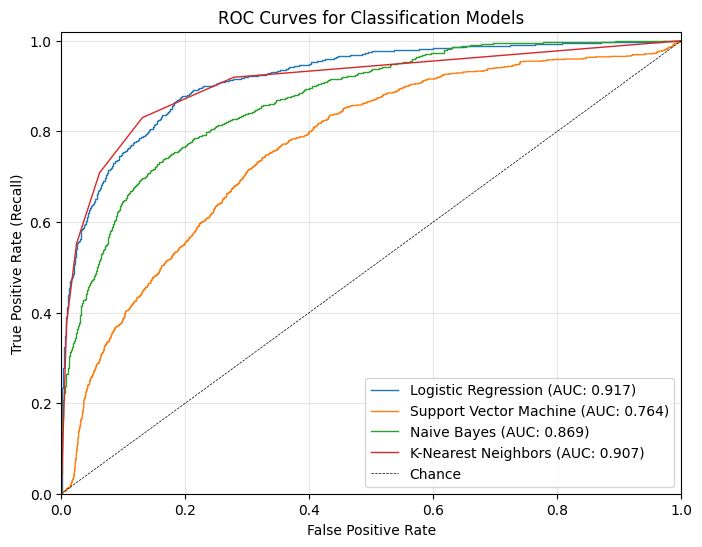

In [55]:
plt.figure(figsize=(8,6))
for name, clf in models.items():
    scores = positive_scores(clf, X_test, POS)
    fpr, tpr, _ = roc_curve(y_test, scores, pos_label=POS)
    roc_auc = auc(fpr, tpr)                   # same as roc_auc_score(y_test, scores, labels=[...])
    plt.plot(fpr, tpr, lw=1, label=f"{name} (AUC: {roc_auc:.3f})")

# Chance line
plt.plot([0,1], [0,1], 'k--', lw=0.5, label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for Classification Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Usually a model's threshold is set at 0.5, meaning that if the model's prediction is above 0.5, it classifies the house as 'high value', and it is is below 0.5, it classifies it as 'low value'. However, this threshold can be adjusted to optimize the model's performance. Using the chart above, we can make a determination that if we set the threshold at 0.3, the model would be better at identifying 'high value' houses.

In [56]:
log_scores = positive_scores(lrBase, X_test, POS)
for thr in (0.5, 0.8):
    y_pred_thr = (log_scores >= thr).astype(int)  # needs y_test encoded {0,1} OR map below
    # If y_test is labels, map to {0,1} with POS=1
    if y_test.dtype.kind not in "iu":  # not int/uint
        y_true_bin = (y_test == POS).astype(int)
    else:
        y_true_bin = y_test
    print(f"\nLogistic Regression @ threshold={thr}")
    print(classification_report(y_true_bin, y_pred_thr, target_names=["Low Value", "High Value"]))


Logistic Regression @ threshold=0.5
              precision    recall  f1-score   support

   Low Value       0.89      0.94      0.92      3044
  High Value       0.79      0.67      0.72      1043

    accuracy                           0.87      4087
   macro avg       0.84      0.80      0.82      4087
weighted avg       0.87      0.87      0.87      4087


Logistic Regression @ threshold=0.8
              precision    recall  f1-score   support

   Low Value       0.82      0.99      0.90      3044
  High Value       0.95      0.36      0.52      1043

    accuracy                           0.83      4087
   macro avg       0.88      0.67      0.71      4087
weighted avg       0.85      0.83      0.80      4087



When the threshold is set to 0.5, we see 'balanced sensitivity'.

1. The model labels a house 'high value' if its probability of being 'high value' is above 0.5.
2. It catches 67% of truly high-value houses (recall (True Positive Rate) = 0.67).
3. About 79% of the houses it calls 'high value' are actually high-value (precision = 0.79).
4. Overall accuracy is 0.87

When the threshold is set to 0.8, we see 'conservative decision rule.'
1. Now the model only predicts 'high value' if its probability of being 'high value' is above 0.8. This means that the model is more confident in its predictions.
2. The precision jumps to 0.95 - almost every house it labels as 'high value' is actually high-value (precision = 0.95).
3. The recall drops to 0.36 - it now misses nearly two-thirds of actual high-value houses.
4. Overall accuracy slips to 0.83

On the ROC curve, this would mean that we moved leftward (lower false-positive rate) and downward (lower true positive rate).